In [3]:
# ================================
# PCA (Excel, Jupyter) — EN labels, stable plots, KMO-selection, pretty outputs
# ================================

## Packages
req <- c("readxl","psych","dplyr","ggplot2","corrplot","tibble",
         "knitr","GPArotation","ggrepel","Matrix","factoextra","grid")
to_install <- req[!req %in% rownames(installed.packages())]
if(length(to_install) > 0) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

## ---- PATHS: EDIT HERE ----
base_dir  <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"   # << folder
excel_file<- file.path(base_dir, "Sophia_Data.xls")                      # << exact filename
sheet_name<- NULL   # << e.g. "Sheet1"; NULL = first sheet
out_dir   <- file.path(base_dir, "PCA_B")                         # << output folder
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)

## Helpers (no HTML)
graphics.off()
show_h1 <- function(txt){ cat("\n\n==== ", txt, " ====\n", sep="") }
note    <- function(txt){  cat("Note: ", txt, "\n", sep = "") }
warnln  <- function(txt){  cat("⚠️  ", txt, "\n", sep = "") }
okln    <- function(txt){  cat("✅ ", txt, "\n", sep = "") }
show_tbl<- function(df, caption=NULL){ print(knitr::kable(df, format="simple", caption=caption, align="l")) }
to_numeric_df <- function(df){
  out <- df
  out[] <- lapply(out, function(x){
    if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
    else { suppressWarnings(as.numeric(x)) }
  })
  out
}
# ensure plots appear in order AND are saved
plot_save_show_gg <- function(p, file, width_cm=18, height_cm=12, dpi=300){
  print(p)  # show now
  ggplot2::ggsave(filename = file, plot = p, width = width_cm, height = height_cm, units = "cm", dpi = dpi)
}
plot_save_show_base <- function(plot_expr, file, width_px=1800, height_px=1400, res=180){
  graphics.off(); par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # show in notebook
  png(filename = file, width = width_px, height = height_px, res = res)
  par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # save
  dev.off()
  invisible(NULL)
}

## ---- VARIABLES: EDIT HERE ----
VARS <- c(
  "Chlorophyll_ugperL",
  "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
  "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5","Air_temp"
)

## Load data
stopifnot("Excel file not found." = file.exists(excel_file))
sheets <- readxl::excel_sheets(excel_file); if(is.null(sheet_name)) sheet_name <- sheets[1]
raw <- read_excel(excel_file, sheet = sheet_name)

## Select & numeric
if(!all(VARS %in% names(raw))){
  miss <- setdiff(VARS, names(raw))
  stop(paste0("Missing variables in '", sheet_name, "': ", paste(miss, collapse=", ")))
}
dat <- raw[, VARS, drop = FALSE]
dat_num <- to_numeric_df(dat)

## Complete cases
n0 <- nrow(dat_num)
dat_cc <- na.omit(dat_num)
n_used <- nrow(dat_cc); n_removed <- n0 - n_used

show_h1("Data overview")
show_tbl(data.frame(Total_rows=n0, Complete_rows=n_used, Removed_due_to_NA=n_removed),
         "Row counts")

# ------------------------------------------------------------
# A) KMO-optimised variable selection (stabilise PCA)
# ------------------------------------------------------------
kmo_for <- function(df, cols){
  X <- df[, cols, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]
  if(nrow(X) < 10 || ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  sds <- sapply(X, sd, na.rm=TRUE); if(any(sds<=0 | !is.finite(sds))) X <- X[, sds>0 & is.finite(sds), drop=FALSE]
  if(ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  R <- suppressWarnings(cor(X, use="complete.obs"))
  ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
  if(min(ev) <= 1e-8) R <- as.matrix(Matrix::nearPD(R, corr=TRUE)$mat)
  km <- tryCatch(psych::KMO(R), error=function(e) NULL)
  if(is.null(km)) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=R))
  list(ok=TRUE, KMO=as.numeric(km$MSA), MSAi=km$MSAi, R=R)
}
round70 <- function(x) !is.na(x) && (round(x,2) >= 0.70)

vars_all <- intersect(VARS, colnames(dat_cc))
comp_in  <- intersect(grep("^pctComp\\.", vars_all, value=TRUE), vars_all)
cur <- vars_all
history <- tibble::tibble(Step=0L, p=length(cur), Removed="–", Set="start", KMO=NA_real_)
res <- kmo_for(dat_cc, cur); history$KMO[1] <- res$KMO

best_set <- cur; best_res <- res
if(length(comp_in) > 0){
  for(k in 1:length(comp_in)){
    cmb <- combn(comp_in, k, simplify=FALSE)
    evals <- lapply(cmb, function(rem){ cols <- setdiff(vars_all, rem); list(rem=rem, out=kmo_for(dat_cc, cols), cols=cols) })
    ok <- Filter(function(z) isTRUE(z$out$ok), evals)
    if(length(ok)){
      ks <- sapply(ok, function(z) z$out$KMO); imax <- which.max(ks); cand <- ok[[imax]]
      history <- dplyr::add_row(history, Step=nrow(history), p=length(cand$cols),
                                Removed=paste(cand$rem, collapse=", "), Set="only_pctComp", KMO=cand$out$KMO)
      if(round70(cand$out$KMO)){ best_set <- cand$cols; best_res <- cand$out; break }
      if(is.na(best_res$KMO) || cand$out$KMO > best_res$KMO){ best_set <- cand$cols; best_res <- cand$out }
    }
  }
  cur <- best_set; res <- best_res
}
if(!round70(res$KMO)){
  improved <- TRUE
  while(!round70(res$KMO) && improved && length(cur) > 3){
    improved <- FALSE
    trials <- lapply(seq_along(cur), function(i){ cand <- cur[-i]; out <- kmo_for(dat_cc, cand)
      list(var=cur[i], KMO=out$KMO, ok=out$ok, cols=cand, out=out) })
    trials <- Filter(function(z) isTRUE(z$ok), trials); if(length(trials)==0) break
    imax <- which.max(sapply(trials, `[[`, "KMO")); pick <- trials[[imax]]
    if(is.na(res$KMO) || (pick$KMO > res$KMO + 1e-4)){
      history <- dplyr::add_row(history, Step=nrow(history), p=length(pick$cols),
                                Removed=pick$var, Set="greedy_rest", KMO=pick$KMO)
      cur <- pick$cols; res <- pick$out; improved <- TRUE
    } else break
  }
}
SEL_VARS <- cur
show_h1("KMO-driven selection")
show_tbl(history, "KMO path (steps)")
write.csv(history, file.path(out_dir, "KMO_path_selection.csv"), row.names=FALSE)
kmo_df <- data.frame(Variable=names(res$MSAi), MSA=round(as.numeric(res$MSAi),3)) %>% dplyr::arrange(MSA)
show_tbl(kmo_df, "MSA per variable (ascending)")
write.csv(kmo_df, file.path(out_dir, "KMO_MSA_final.csv"), row.names=FALSE)

# ------------------------------------------------------------
# B) Correlation (on selected vars) + correlation triangle
# ------------------------------------------------------------
dat_cc_sel <- dat_cc[, SEL_VARS, drop=FALSE]
R    <- cor(dat_cc_sel, use = "pairwise.complete.obs")
ev_R <- eigen(R, symmetric=TRUE, only.values=TRUE)$values
write.csv(round(R,3),    file.path(out_dir,"01_Correlation_matrix.csv"))
write.csv(round(ev_R,6), file.path(out_dir,"02_Eigenvalues_of_R.csv"), row.names=FALSE)

show_h1("Correlation matrix & eigenvalues")
show_tbl(round(R,3), "Correlation matrix (Pearson)")
ev_tbl <- data.frame(Component=paste0("EV", seq_along(ev_R)), Eigenvalue=round(ev_R,4))
show_tbl(ev_tbl, "Eigenvalues of correlation matrix")

# ---------- Pretty block: Matrix definiteness (display + save) ----------
classify_definiteness <- function(ev, abs_tol = 1e-8, rel_tol = 1e-6){
  thr <- max(abs_tol, rel_tol * max(abs(ev), na.rm = TRUE))
  pd  <- all(ev >  thr, na.rm = TRUE)
  psd <- all(ev >= -thr, na.rm = TRUE)
  sing <- psd && any(ev <  thr, na.rm = TRUE)
  status <- if(pd) "positive definite" else if(sing) "positive semidefinite (singular)" else if(psd) "positive semidefinite" else "NOT positive semidefinite"
  list(status=status, thr=thr, pd=pd, psd=psd, singular=sing)
}
pretty_definiteness <- function(R, ev, out_dir){
  det_R <- det(R)
  kap   <- tryCatch(kappa(R), error=function(e) NA_real_)
  rcond <- if(is.finite(kap)) 1/kap else NA_real_
  dres  <- classify_definiteness(ev)
  show_h1("Definiteness of correlation matrix (pretty)")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  if(dres$status == "positive definite"){
    okln("Matrix is positive definite → PCA is numerically stable.")
  } else if(dres$status == "positive semidefinite (singular)"){
    warnln("Matrix is only positive semidefinite (singular) → near-linear dependencies.")
  } else if(dres$status == "positive semidefinite"){
    warnln("Matrix is positive semidefinite (not strictly PD) → caution with inversions.")
  } else {
    warnln("Matrix is NOT positive semidefinite → negative eigenvalues present.")
  }
  # save
  con <- file.path(out_dir, "01c_Definiteness_pretty.txt")
  sink(con)
  cat("==== Correlation Matrix Definiteness ====\n")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  sink()
  invisible(dres)
}
dres <- pretty_definiteness(R, ev_R, out_dir)

# Correlation triangle — show & save
show_h1("Correlation triangle (upper)")
plot_save_show_base(
  corrplot::corrplot(R, type="upper", order="hclust", tl.col="black",
                     addCoef.col="black", number.cex=0.6),
  file = file.path(out_dir,"01b_CorrTriangle.png"),
  width_px = 1800, height_px = 1600, res = 200
)

# ------------------------------------------------------------
# C) 3 component selection criteria (PCA only)
# ------------------------------------------------------------
# 1) Kaiser (EV > 1)
n_kaiser <- sum(ev_R > 1)
kaiser_tbl <- data.frame(
  Component = seq_along(ev_R),
  Eigenvalue = round(ev_R,4),
  Kaiser_gt1 = ev_R > 1
)
show_h1("Criterion 1 — Kaiser (eigenvalue > 1)")
show_tbl(kaiser_tbl, "Kaiser rule table")
write.csv(kaiser_tbl, file.path(out_dir, "20_Components_Kaiser.csv"), row.names=FALSE)

# 2) Screeplot — show & save
show_h1("Criterion 2 — Scree plot")
scree_df <- data.frame(Component=seq_along(ev_R), Eigenvalue=ev_R)
p_scree <- ggplot(scree_df, aes(Component, Eigenvalue))+
  geom_point(size=2)+geom_line()+
  geom_hline(yintercept=1, linetype="dashed")+
  labs(title="Scree plot (eigenvalues of correlation matrix)", x="Component", y="Eigenvalue")+
  theme_minimal(base_size = 12)
plot_save_show_gg(p_scree, file.path(out_dir,"21_Screeplot.png"))

# 3) Parallel Analysis (PCA) — show & save
show_h1("Criterion 3 — Parallel analysis (PCA)")
graphics.off(); par(mfrow=c(1,1))
fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
png(file.path(out_dir,"22_Parallel_Analysis.png"), width=1800, height=1200, res=180)
par(mfrow=c(1,1))
fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
dev.off()
pa_res <- fa.parallel(dat_cc_sel, fm="pc", fa="pc", plot=FALSE)
n_pa <- sum(pa_res$pc.values > pa_res$pc.sim)
cat("Results → PA: ", n_pa, " components | Kaiser: ", n_kaiser, " components.\n", sep="")

# >>> FINAL CHOICE: Kaiser (EV > 1)
ncomp <- max(1, n_kaiser)
show_h1("Final number of components (chosen: Kaiser)")
cat("ncomp = ", ncomp, " (eigenvalue > 1)\n", sep="")

# ------------------------------------------------------------
# D) PCA only + varimax (display & save) + single biplots
# ------------------------------------------------------------
pca_unrot <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="none",   scores=TRUE, covar=FALSE)
pca_rot   <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="varimax", scores=TRUE, covar=FALSE)

# Variance tables
var_unrot <- data.frame(
  Component=paste0("PC",seq_len(ncomp)),
  Eigenvalue=round(pca_unrot$values[seq_len(ncomp)],4),
  Proportion=round(pca_unrot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative=round(pca_unrot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — unrotated")
show_tbl(var_unrot, "Variance accounted (unrotated)")
write.csv(var_unrot, file.path(out_dir,"06_Variance_unrotated.csv"), row.names=FALSE)

var_rot <- data.frame(
  Component=paste0("PC",seq_len(ncomp)),
  Eigenvalue_rot=round(pca_rot$values[seq_len(ncomp)],4),
  Proportion_rot=round(pca_rot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative_rot=round(pca_rot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — varimax")
show_tbl(var_rot, "Variance accounted (varimax)")
write.csv(var_rot, file.path(out_dir,"09_Variance_varimax.csv"), row.names=FALSE)

# Loadings & communalities
load_unrot <- as.data.frame(unclass(pca_unrot$loadings))
commu_unrot<- data.frame(Variable=rownames(load_unrot), Communality=round(rowSums(load_unrot^2),4))
show_h1("Loadings — unrotated (top 10 rows)")
show_tbl(head(round(load_unrot,3), 10))
write.csv(round(load_unrot,4), file.path(out_dir,"07_Loadings_unrotated.csv"))
write.csv(commu_unrot, file.path(out_dir,"08_Communalities_unrotated.csv"), row.names=FALSE)

load_rot <- as.data.frame(unclass(pca_rot$loadings))
commu_rot<- data.frame(Variable=rownames(load_rot), Communality_rot=round(rowSums(load_rot^2),4))
show_h1("Loadings — varimax (top 10 rows)")
show_tbl(head(round(load_rot,3), 10))
write.csv(round(load_rot,4), file.path(out_dir,"10_Loadings_varimax.csv"))
write.csv(commu_rot, file.path(out_dir,"11_Communalities_varimax.csv"), row.names=FALSE)

# ---- Biplot (unrotated) — shown & saved alone ----
show_h1("Biplot — unrotated")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_unrot, main="Biplot — unrotated")),
  file = file.path(out_dir,"14_Biplot_unrotated.png"),
  width_px = 1800, height_px = 1400, res = 180
)

# ---- Biplot (varimax) — shown & saved alone ----
show_h1("Biplot — varimax")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_rot, main="Biplot — varimax")),
  file = file.path(out_dir,"15_Biplot_varimax.png"),
  width_px = 1800, height_px = 1400, res = 180
)

# ------------------------------------------------------------
# E) KMO / Bartlett (on selection) — compute
# ------------------------------------------------------------
kmo  <- tryCatch(KMO(R), error=function(e){ warnln(paste("KMO failed:", e$message)); NULL })
bart <- tryCatch(cortest.bartlett(R, n = nrow(dat_cc_sel)), error=function(e){ warnln(paste("Bartlett failed:", e$message)); NULL })
if(!is.null(kmo)){
  msa_tbl2 <- data.frame(Variable = colnames(R), MSA = round(kmo$MSAi,3))
  write.csv(msa_tbl2, file.path(out_dir,"03_MSA_per_variable.csv"), row.names=FALSE)
}

# ---------- Pretty block: KMO / Bartlett (display + save) ----------
pretty_kmo_bartlett <- function(kmo_obj, bart_obj, out_dir){
  show_h1("KMO / Bartlett (after selection)")
  msa_overall <- if(!is.null(kmo_obj)) as.numeric(kmo_obj$MSA) else NA_real_
  p_bart      <- if(!is.null(bart_obj)) as.numeric(bart_obj$p.value) else NA_real_
  chi_bart    <- if(!is.null(bart_obj)) as.numeric(bart_obj$chisq) else NA_real_
  df_bart     <- if(!is.null(bart_obj)) as.integer(bart_obj$df) else NA_integer_
  kmo_ok  <- !is.na(msa_overall) && msa_overall >= 0.60
  kmo_good<- !is.na(msa_overall) && msa_overall >= 0.80
  bart_ok <- !is.na(p_bart) && p_bart < 0.05

  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥0.6 ok, ≥0.8 good)\n", sep="")
  if(kmo_ok){
    okln(if(kmo_good) "KMO/MSA good." else "KMO/MSA adequate.")
  } else {
    warnln("KMO/MSA < 0.6 — sampling adequacy questionable.")
  }

  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  if(bart_ok){
    okln("Bartlett p < 0.05 → factorability acceptable.")
  } else {
    warnln("Bartlett p ≥ 0.05 — correlations may be insufficient.")
  }

  con <- file.path(out_dir, "04b_KMO_Bartlett_pretty.txt")
  sink(con)
  cat("==== KMO / Bartlett (after selection) ====\n")
  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥0.6 ok, ≥0.8 good)\n", sep="")
  cat(if(kmo_ok) "✅ " else "⚠️ ", if(kmo_good) "KMO/MSA good.\n" else if(kmo_ok) "KMO/MSA adequate.\n" else "KMO/MSA < 0.6 — questionable.\n", sep="")
  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  cat(if(bart_ok) "✅ Bartlett p < 0.05 → factorability acceptable.\n"
      else "⚠️ Bartlett p ≥ 0.05 — insufficient correlations.\n")
  sink()
  note(paste0("Saved: ", con))
}
pretty_kmo_bartlett(kmo, bart, out_dir)

# ------------------------------------------------------------
# F) Compact summary
# ------------------------------------------------------------
sink(file.path(out_dir,"00_Summary.txt"))
cat("Component selection (PCA only): Kaiser(EV>1)=", n_kaiser, " | PA=", n_pa, "\n", sep="")
cat("Chosen (Kaiser): ncomp=", ncomp, "\n", sep="")
cat("Variables used: ", paste(SEL_VARS, collapse=", "), "\n", sep="")
cat("Complete cases: ", n_used, " (of ", n0, ")\n", sep="")
sink()

show_h1("Summary")
cat("Kaiser(EV>1): ", n_kaiser, " | PA: ", n_pa, " → chosen: ", ncomp, "\n", sep="")
cat("Outputs saved to: ", out_dir, "\n", sep="")




==== Data overview ====


Table: Row counts

Total_rows   Complete_rows   Removed_due_to_NA 
-----------  --------------  ------------------
57           41              16                


==== KMO-driven selection ====


Table: KMO path (steps)

Step   p    Removed                Set            KMO       
-----  ---  ---------------------  -------------  ----------
0      11   –                      start          0.4406049 
1      10   pctComp.5              only_pctComp   0.6709135 
2      9    pctComp.1, pctComp.5   only_pctComp   0.7051416 


Table: MSA per variable (ascending)

Variable             MSA   
-------------------  ------
pH                   0.296 
Turbidity_FNU        0.541 
BGA_PC_ugperL        0.612 
pctComp.2            0.638 
Chlorophyll_ugperL   0.639 
pctComp.4            0.708 
pctComp.3            0.716 
Air_temp             0.909 
ODO_mgperL           0.927 


==== Correlation matrix & eigenvalues ====


Table: Correlation matrix (Pearson)

             

factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 


factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 


png 
  2

factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 
Results → PA: 2 components | Kaiser: 2 components.


==== Final number of components (chosen: Kaiser) ====
ncomp = 2 (eigenvalue > 1)


==== Variance explained — unrotated ====


Table: Variance accounted (unrotated)

      Component   Eigenvalue   Proportion   Cumulative 
----  ----------  -----------  -----------  -----------
PC1   PC1         4.4868       0.4985       0.4985     
PC2   PC2         1.5257       0.1695       0.6681     


==== Variance explained — varimax ====


Table: Variance accounted (varimax)

      Component   Eigenvalue_rot   Proportion_rot   Cumulative_rot 
----  ----------  ---------------  ---------------  ---------------
RC1   PC1         4.4868           0.3505           0.3505         
RC2   PC2         1.5257           0.3175           0.6681         


==== Loadings — unrotated (top 10 rows) ====


                     PC1      PC2    
-------------------  --

In [7]:
# ================================
# PCA (Excel, Jupyter) — EN labels, stable plots, KMO-selection, pretty outputs
# + Added tables: component matrix, assigned variables (threshold), communalities
# ================================

## -----------------------------
## USER SETTINGS (edit here)
## -----------------------------
base_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"   # input folder
excel_file <- file.path(base_dir, "Sophia_Data.xls")                      # exact Excel filename
sheet_name <- NULL                                                        # e.g. "Sheet1"; NULL=first sheet
out_dir    <- file.path(base_dir, "PCA_B")                         # output folder

VARS <- c( # variables to consider (will be filtered by KMO routine)
  "average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
  "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
  "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5","Air_temp"
)

KMO_TARGET  <- 0.70   # target KMO for selection routine (change to 0.50 if you like)
LOAD_THRESH <- 0.50   # absolute loading cutoff for "assigned variables" tables

## -----------------------------
## Packages
## -----------------------------
req <- c("readxl","psych","dplyr","ggplot2","corrplot","tibble",
         "knitr","GPArotation","ggrepel","Matrix","factoextra","grid")
to_install <- req[!req %in% rownames(installed.packages())]
if(length(to_install) > 0) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

## -----------------------------
## Helpers (no HTML)
## -----------------------------
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
graphics.off()
show_h1 <- function(txt){ cat("\n\n==== ", txt, " ====\n", sep="") }
note    <- function(txt){  cat("Note: ", txt, "\n", sep = "") }
warnln  <- function(txt){  cat("⚠️  ", txt, "\n", sep = "") }
okln    <- function(txt){  cat("✅ ", txt, "\n", sep = "") }
show_tbl<- function(df, caption=NULL){ print(knitr::kable(df, format="simple", caption=caption, align="l")) }

to_numeric_df <- function(df){
  out <- df
  out[] <- lapply(out, function(x){
    if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
    else { suppressWarnings(as.numeric(x)) }
  })
  out
}

# stable plotting: show first, then save
plot_save_show_gg <- function(p, file, width_cm=18, height_cm=12, dpi=300){
  print(p)  # show in notebook
  ggplot2::ggsave(filename = file, plot = p, width = width_cm, height = height_cm, units = "cm", dpi = dpi)
}
plot_save_show_base <- function(plot_expr, file, width_px=1800, height_px=1400, res=180){
  graphics.off(); par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # show
  png(filename = file, width = width_px, height = height_px, res = res)
  par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # save
  dev.off()
  invisible(NULL)
}

## -----------------------------
## Load data
## -----------------------------
stopifnot("Excel file not found." = file.exists(excel_file))
sheets <- readxl::excel_sheets(excel_file); if(is.null(sheet_name)) sheet_name <- sheets[1]
raw <- read_excel(excel_file, sheet = sheet_name)

if(!all(VARS %in% names(raw))){
  miss <- setdiff(VARS, names(raw))
  stop(paste0("Missing variables in '", sheet_name, "': ", paste(miss, collapse=", ")))
}

dat <- raw[, VARS, drop = FALSE]
dat_num <- to_numeric_df(dat)

n0 <- nrow(dat_num)
dat_cc <- na.omit(dat_num)
n_used <- nrow(dat_cc); n_removed <- n0 - n_used

show_h1("Data overview")
show_tbl(data.frame(Total_rows=n0, Complete_rows=n_used, Removed_due_to_NA=n_removed),
         "Row counts")

## -----------------------------
## KMO-driven variable selection (stabilises PCA)
## 1) test pctComp.* removals; 2) greedy if still below target
## -----------------------------
kmo_for <- function(df, cols){
  X <- df[, cols, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]
  if(nrow(X) < 10 || ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  sds <- sapply(X, sd, na.rm=TRUE); if(any(sds<=0 | !is.finite(sds))) X <- X[, sds>0 & is.finite(sds), drop=FALSE]
  if(ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  R <- suppressWarnings(cor(X, use="complete.obs"))
  ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
  if(min(ev) <= 1e-8) R <- as.matrix(Matrix::nearPD(R, corr=TRUE)$mat)
  km <- tryCatch(psych::KMO(R), error=function(e) NULL)
  if(is.null(km)) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=R))
  list(ok=TRUE, KMO=as.numeric(km$MSA), MSAi=km$MSAi, R=R)
}
round_ok <- function(x) !is.na(x) && (round(x,2) >= KMO_TARGET)

vars_all <- intersect(VARS, colnames(dat_cc))
comp_in  <- intersect(grep("^pctComp\\.", vars_all, value=TRUE), vars_all)
cur <- vars_all
history <- tibble::tibble(Step=0L, p=length(cur), Removed="–", Set="start", KMO=NA_real_)
res <- kmo_for(dat_cc, cur); history$KMO[1] <- res$KMO

best_set <- cur; best_res <- res
if(length(comp_in) > 0){
  for(k in 1:length(comp_in)){
    cmb <- combn(comp_in, k, simplify=FALSE)
    evals <- lapply(cmb, function(rem){
      cols <- setdiff(vars_all, rem)
      list(rem=rem, out=kmo_for(dat_cc, cols), cols=cols)
    })
    ok <- Filter(function(z) isTRUE(z$out$ok), evals)
    if(length(ok)){
      ks <- sapply(ok, function(z) z$out$KMO); imax <- which.max(ks); cand <- ok[[imax]]
      history <- dplyr::add_row(history, Step=nrow(history), p=length(cand$cols),
                                Removed=paste(cand$rem, collapse=", "), Set="only_pctComp", KMO=cand$out$KMO)
      if(round_ok(cand$out$KMO)){ best_set <- cand$cols; best_res <- cand$out; break }
      if(is.na(best_res$KMO) || cand$out$KMO > best_res$KMO){ best_set <- cand$cols; best_res <- cand$out }
    }
  }
  cur <- best_set; res <- best_res
}
if(!round_ok(res$KMO)){
  improved <- TRUE
  while(!round_ok(res$KMO) && improved && length(cur) > 3){
    improved <- FALSE
    trials <- lapply(seq_along(cur), function(i){
      cand <- cur[-i]; out <- kmo_for(dat_cc, cand)
      list(var=cur[i], KMO=out$KMO, ok=out$ok, cols=cand, out=out)
    })
    trials <- Filter(function(z) isTRUE(z$ok), trials); if(length(trials)==0) break
    imax <- which.max(sapply(trials, `[[`, "KMO")); pick <- trials[[imax]]
    if(is.na(res$KMO) || (pick$KMO > res$KMO + 1e-4)){
      history <- dplyr::add_row(history, Step=nrow(history), p=length(pick$cols),
                                Removed=pick$var, Set="greedy_rest", KMO=pick$KMO)
      cur <- pick$cols; res <- pick$out; improved <- TRUE
    } else break
  }
}
SEL_VARS <- cur
show_h1("KMO-driven selection")
show_tbl(history, "KMO path (steps)")
write.csv(history, file.path(out_dir, "KMO_path_selection.csv"), row.names=FALSE)
kmo_df <- data.frame(Variable=names(res$MSAi), MSA=round(as.numeric(res$MSAi),3)) %>% dplyr::arrange(MSA)
show_tbl(kmo_df, "MSA per variable (ascending)")
write.csv(kmo_df, file.path(out_dir, "KMO_MSA_final.csv"), row.names=FALSE)

## -----------------------------
## Correlation & eigenvalues (selected vars) + correlation triangle
## -----------------------------
dat_cc_sel <- dat_cc[, SEL_VARS, drop=FALSE]
R    <- cor(dat_cc_sel, use = "pairwise.complete.obs")
ev_R <- eigen(R, symmetric=TRUE, only.values=TRUE)$values
write.csv(round(R,3),    file.path(out_dir,"01_Correlation_matrix.csv"))
write.csv(round(ev_R,6), file.path(out_dir,"02_Eigenvalues_of_R.csv"), row.names=FALSE)

show_h1("Correlation matrix & eigenvalues")
show_tbl(round(R,3), "Correlation matrix (Pearson)")
ev_tbl <- data.frame(Component=paste0("EV", seq_along(ev_R)), Eigenvalue=round(ev_R,4))
show_tbl(ev_tbl, "Eigenvalues of correlation matrix")

# Pretty block: Matrix definiteness (display + save)
classify_definiteness <- function(ev, abs_tol = 1e-8, rel_tol = 1e-6){
  thr <- max(abs_tol, rel_tol * max(abs(ev), na.rm = TRUE))
  pd  <- all(ev >  thr, na.rm = TRUE)
  psd <- all(ev >= -thr, na.rm = TRUE)
  sing <- psd && any(ev <  thr, na.rm = TRUE)
  status <- if(pd) "positive definite" else if(sing) "positive semidefinite (singular)" else if(psd) "positive semidefinite" else "NOT positive semidefinite"
  list(status=status, thr=thr, pd=pd, psd=psd, singular=sing)
}
pretty_definiteness <- function(R, ev, out_dir){
  det_R <- det(R)
  kap   <- tryCatch(kappa(R), error=function(e) NA_real_)
  rcond <- if(is.finite(kap)) 1/kap else NA_real_
  dres  <- classify_definiteness(ev)
  show_h1("Definiteness of correlation matrix (pretty)")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  if(dres$status == "positive definite"){
    okln("Matrix is positive definite → PCA is numerically stable.")
  } else if(dres$status == "positive semidefinite (singular)"){
    warnln("Matrix is only positive semidefinite (singular) → near-linear dependencies.")
  } else if(dres$status == "positive semidefinite"){
    warnln("Matrix is positive semidefinite (not strictly PD) → caution with inversions.")
  } else {
    warnln("Matrix is NOT positive semidefinite → negative eigenvalues present.")
  }
  con <- file.path(out_dir, "01c_Definiteness_pretty.txt")
  sink(con)
  cat("==== Correlation Matrix Definiteness ====\n")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  sink()
  invisible(dres)
}
dres <- pretty_definiteness(R, ev_R, out_dir)

# Correlation triangle — show & save
show_h1("Correlation triangle (upper)")
plot_save_show_base(
  corrplot::corrplot(R, type="upper", order="hclust", tl.col="black",
                     addCoef.col="black", number.cex=0.6),
  file = file.path(out_dir,"01b_CorrTriangle.png"),
  width_px = 1800, height_px = 1600, res = 200
)

## -----------------------------
## Component selection criteria (PCA only)
## -----------------------------
# 1) Kaiser (EV > 1)
n_kaiser <- sum(ev_R > 1)
kaiser_tbl <- data.frame(
  Component = seq_along(ev_R),
  Eigenvalue = round(ev_R,4),
  Kaiser_gt1 = ev_R > 1
)
show_h1("Criterion 1 — Kaiser (eigenvalue > 1)")
show_tbl(kaiser_tbl, "Kaiser rule table")
write.csv(kaiser_tbl, file.path(out_dir, "20_Components_Kaiser.csv"), row.names=FALSE)

# 2) Scree plot
show_h1("Criterion 2 — Scree plot")
scree_df <- data.frame(Component=seq_along(ev_R), Eigenvalue=ev_R)
p_scree <- ggplot(scree_df, aes(Component, Eigenvalue))+
  geom_point(size=2)+geom_line()+
  geom_hline(yintercept=1, linetype="dashed")+
  labs(title="Scree plot (eigenvalues of correlation matrix)", x="Component", y="Eigenvalue")+
  theme_minimal(base_size = 12)
plot_save_show_gg(p_scree, file.path(out_dir,"21_Screeplot.png"))

# 3) Parallel analysis (PCA)
show_h1("Criterion 3 — Parallel analysis (PCA)")
graphics.off(); par(mfrow=c(1,1))
fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
png(file.path(out_dir,"22_Parallel_Analysis.png"), width=1800, height=1200, res=180)
par(mfrow=c(1,1))
fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
dev.off()
pa_res <- fa.parallel(dat_cc_sel, fm="pc", fa="pc", plot=FALSE)
n_pa <- sum(pa_res$pc.values > pa_res$pc.sim)
cat("Results → PA: ", n_pa, " components | Kaiser: ", n_kaiser, " components.\n", sep="")

# Final choice: Kaiser
ncomp <- max(1, n_kaiser)
show_h1("Final number of components (chosen: Kaiser)")
cat("ncomp = ", ncomp, " (eigenvalue > 1)\n", sep="")

## -----------------------------
## PCA (unrotated & varimax) + tables & biplots
## -----------------------------
pca_unrot <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="none",   scores=TRUE, covar=FALSE)
pca_rot   <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="varimax", scores=TRUE, covar=FALSE)

# Variance tables
var_unrot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue = round(pca_unrot$values[seq_len(ncomp)],4),
  Proportion = round(pca_unrot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative = round(pca_unrot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — unrotated"); show_tbl(var_unrot)
write.csv(var_unrot, file.path(out_dir,"06_Variance_unrotated.csv"), row.names=FALSE)

var_rot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue_rot   = round(pca_rot$values[seq_len(ncomp)],4),
  Proportion_rot   = round(pca_rot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative_rot   = round(pca_rot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — varimax"); show_tbl(var_rot)
write.csv(var_rot, file.path(out_dir,"09_Variance_varimax.csv"), row.names=FALSE)

# Loadings & Communalities (unrotated)
load_unrot <- as.data.frame(unclass(pca_unrot$loadings))
commu_unrot<- data.frame(Variable=rownames(load_unrot),
                         Communality=round(rowSums(load_unrot^2),6))
write.csv(round(load_unrot,6), file.path(out_dir,"07_Loadings_unrotated.csv"))
write.csv(commu_unrot,       file.path(out_dir,"08_Communalities_unrotated.csv"), row.names=FALSE)

# Loadings (varimax) & Communalities (rotation preserves communalities)
load_rot <- as.data.frame(unclass(pca_rot$loadings))
commu_rot<- data.frame(Variable=rownames(load_rot),
                       Communality_rot=round(rowSums(load_rot^2),6))
write.csv(round(load_rot,6), file.path(out_dir,"10_Loadings_varimax.csv"))
write.csv(commu_rot,       file.path(out_dir,"11_Communalities_varimax.csv"), row.names=FALSE)

# --------------------------
# NEW TABLE 1: Component matrix (unrotated) — show & save
# --------------------------
show_h1(sprintf("Component matrix (unrotated) — %d components", ncomp))
comp_mat_unrot <- round(load_unrot[, seq_len(ncomp), drop=FALSE], 3)
colnames(comp_mat_unrot) <- paste0("Factor ", seq_len(ncomp))
comp_mat_unrot <- cbind(Variable = rownames(comp_mat_unrot), comp_mat_unrot, row.names = NULL)
show_tbl(comp_mat_unrot, "Correlation coefficients (loadings) per component")
write.csv(comp_mat_unrot, file.path(out_dir,"30_ComponentMatrix_unrotated.csv"), row.names=FALSE)

# --------------------------
# NEW TABLE 2: Assigned variables (unrotated, threshold)
# keep only the factor with max |loading| per variable if >= LOAD_THRESH
# --------------------------
assign_by_threshold <- function(L, thr=0.5){
  A <- as.matrix(L[, seq_len(ncol(L)), drop=FALSE])
  rn <- rownames(A); cn <- colnames(A)
  sel <- apply(abs(A), 1, function(v){
    if(all(is.na(v))) return(rep(NA_real_, length(v)))
    j <- which.max(abs(v)); out <- rep(NA_real_, length(v))
    if(is.finite(v[j]) && abs(v[j]) >= thr) out[j] <- v[j]
    out
  })
  B <- t(sel); colnames(B) <- cn; rownames(B) <- rn
  as.data.frame(B)
}
show_h1(sprintf("Assigned variables (unrotated) — |loading| ≥ %.2f", LOAD_THRESH))
ass_unrot <- assign_by_threshold(load_unrot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_unrot) <- paste0("Factor ", seq_len(ncomp))
ass_unrot_out <- cbind(Variable=rownames(ass_unrot), round(ass_unrot,3), row.names=NULL)
show_tbl(ass_unrot_out, "Variables assigned to components (unrotated)")
write.csv(ass_unrot_out, file.path(out_dir,"31_AssignedVariables_unrotated_threshold.csv"), row.names=FALSE)
note(sprintf("Principal component analysis, with %d components extracted", ncomp))

# --------------------------
# NEW TABLE 3: Communalities table — Initial (=1) vs Extraction
# --------------------------
show_h1("Communalities — initial vs. extraction (unrotated)")
comm_tab <- data.frame(
  Standardised_variables = commu_unrot$Variable,
  Initial = 1.000000,
  Extraction = round(commu_unrot$Communality, 6)
)
show_tbl(comm_tab, "Communalities (PCA extraction)")
write.csv(comm_tab, file.path(out_dir,"32_Communalities_initial_extraction.csv"), row.names=FALSE)

# --------------------------
# NEW TABLE 4: Assigned variables (varimax, threshold)
# --------------------------
show_h1(sprintf("Assigned variables (varimax) — |loading| ≥ %.2f", LOAD_THRESH))
ass_rot <- assign_by_threshold(load_rot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_rot) <- paste0("Factor ", seq_len(ncomp))
ass_rot_out <- cbind(Variable=rownames(ass_rot), round(ass_rot,3), row.names=NULL)
show_tbl(ass_rot_out, "Variables assigned to components (varimax)")
write.csv(ass_rot_out, file.path(out_dir,"33_AssignedVariables_varimax_threshold.csv"), row.names=FALSE)

# Biplots (separate)
show_h1("Biplot — unrotated")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_unrot, main="Biplot — unrotated")),
  file = file.path(out_dir,"14_Biplot_unrotated.png"),
  width_px = 1800, height_px = 1400, res = 180
)
show_h1("Biplot — varimax")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_rot, main="Biplot — varimax")),
  file = file.path(out_dir,"15_Biplot_varimax.png"),
  width_px = 1800, height_px = 1400, res = 180
)

## -----------------------------
## KMO / Bartlett on selected R (pretty display + save)
## -----------------------------
kmo  <- tryCatch(KMO(R), error=function(e){ warnln(paste("KMO failed:", e$message)); NULL })
bart <- tryCatch(cortest.bartlett(R, n = nrow(dat_cc_sel)), error=function(e){ warnln(paste("Bartlett failed:", e$message)); NULL })
if(!is.null(kmo)){
  msa_tbl2 <- data.frame(Variable = colnames(R), MSA = round(kmo$MSAi,3))
  write.csv(msa_tbl2, file.path(out_dir,"03_MSA_per_variable.csv"), row.names=FALSE)
}
pretty_kmo_bartlett <- function(kmo_obj, bart_obj, out_dir){
  show_h1("KMO / Bartlett (after selection)")
  msa_overall <- if(!is.null(kmo_obj)) as.numeric(kmo_obj$MSA) else NA_real_
  p_bart      <- if(!is.null(bart_obj)) as.numeric(bart_obj$p.value) else NA_real_
  chi_bart    <- if(!is.null(bart_obj)) as.numeric(bart_obj$chisq) else NA_real_
  df_bart     <- if(!is.null(bart_obj)) as.integer(bart_obj$df) else NA_integer_
  kmo_ok  <- !is.na(msa_overall) && msa_overall >= KMO_TARGET
  kmo_good<- !is.na(msa_overall) && msa_overall >= 0.80
  bart_ok <- !is.na(p_bart) && p_bart < 0.05

  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  if(kmo_ok){
    okln(if(kmo_good) "KMO/MSA good." else "KMO/MSA adequate.")
  } else {
    warnln(paste0("KMO/MSA < ", KMO_TARGET, " — sampling adequacy questionable."))
  }

  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  if(bart_ok){
    okln("Bartlett p < 0.05 → factorability acceptable.")
  } else {
    warnln("Bartlett p ≥ 0.05 — correlations may be insufficient.")
  }

  con <- file.path(out_dir, "04b_KMO_Bartlett_pretty.txt")
  sink(con)
  cat("==== KMO / Bartlett (after selection) ====\n")
  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  cat(if(kmo_ok) "✅ " else "⚠️ ", if(kmo_good) "KMO/MSA good.\n" else if(kmo_ok) "KMO/MSA adequate.\n" else paste0("KMO/MSA < ", KMO_TARGET, " — questionable.\n"), sep="")
  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  cat(if(bart_ok) "✅ Bartlett p < 0.05 → factorability acceptable.\n"
      else "⚠️ Bartlett p ≥ 0.05 — insufficient correlations.\n")
  sink()
  note(paste0("Saved: ", con))
}
pretty_kmo_bartlett(kmo, bart, out_dir)

## -----------------------------
## Compact summary
## -----------------------------
sink(file.path(out_dir,"00_Summary.txt"))
cat("Component selection (PCA only): Kaiser(EV>1)=", n_kaiser, " | PA=", n_pa, "\n", sep="")
cat("Chosen (Kaiser): ncomp=", ncomp, "\n", sep="")
cat("Variables used: ", paste(SEL_VARS, collapse=", "), "\n", sep="")
cat("Complete cases: ", n_used, " (of ", n0, ")\n", sep="")
sink()

show_h1("Summary")
cat("Kaiser(EV>1): ", n_kaiser, " | PA: ", n_pa, " → chosen: ", ncomp, "\n", sep="")
cat("Outputs saved to: ", out_dir, "\n", sep="")




==== Data overview ====


Table: Row counts

Total_rows   Complete_rows   Removed_due_to_NA 
-----------  --------------  ------------------
57           27              30                


==== KMO-driven selection ====


Table: KMO path (steps)

Step   p    Removed                           Set            KMO       
-----  ---  --------------------------------  -------------  ----------
0      14   –                                 start          0.5223738 
1      13   pctComp.5                         only_pctComp   0.6370510 
2      12   pctComp.4, pctComp.5              only_pctComp   0.6905480 
3      11   pctComp.1, pctComp.4, pctComp.5   only_pctComp   0.6992395 


Table: MSA per variable (ascending)

Variable             MSA   
-------------------  ------
BDOC_pct             0.399 
average_DOC_sample   0.547 
pH                   0.590 
BGA_PC_ugperL        0.614 
Turbidity_FNU        0.666 
Chlorophyll_ugperL   0.676 
pctComp.2            0.723 
ODO_mgperL           0.762

factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  2 


factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  2 


png 
  2

factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 
Results → PA: 2 components | Kaiser: 3 components.


==== Final number of components (chosen: Kaiser) ====
ncomp = 3 (eigenvalue > 1)


==== Variance explained — unrotated ====


      Component   Eigenvalue   Proportion   Cumulative 
----  ----------  -----------  -----------  -----------
PC1   PC1         5.2265       0.4751       0.4751     
PC2   PC2         1.9843       0.1804       0.6555     
PC3   PC3         1.1411       0.1037       0.7593     


==== Variance explained — varimax ====


      Component   Eigenvalue_rot   Proportion_rot   Cumulative_rot 
----  ----------  ---------------  ---------------  ---------------
RC1   PC1         5.2265           0.3050           0.3050         
RC3   PC2         1.9843           0.2889           0.5939         
RC2   PC3         1.1411           0.1653           0.7593         


==== Component matrix (unrotated) — 3 components ====


Tabl

In [9]:
# ================================
# PCA (Excel, Jupyter) — EN labels, stable plots, KMO-selection, pretty outputs
# + Tables: component matrix, assigned variables (threshold), communalities
# ================================

## -----------------------------------------------------------
## >>> EDIT HERE: PATHS, VARIABLES, THRESHOLDS (single place)
## -----------------------------------------------------------
base_dir   <- "C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL"   # <<< change if needed
excel_file <- file.path(base_dir, "Sophia_Data.xls")                      # <<< exact Excel filename
sheet_name <- NULL                                                        # <<< e.g. "Sheet1"; NULL = first
out_dir    <- file.path(base_dir, "PCA_flexibel")                         # <<< output folder

VARS <- c(  # <<< variables to consider
  "average_DOC_sample","BDOC_pct","CO2_Flux","Chlorophyll_ugperL",
  "ODO_mgperL","BGA_PC_ugperL","Turbidity_FNU","pH",
  "pctComp.1","pctComp.2","pctComp.3","pctComp.4","pctComp.5","Air_temp"
)

KMO_TARGET  <- 0.70   # <<< set your KMO target here (e.g., 0.50, 0.60, 0.70 …)
LOAD_THRESH <- 0.50   # <<< absolute loading cutoff for "assigned variables" tables

## -----------------------------------------------------------
## Packages
## -----------------------------------------------------------
req <- c("readxl","psych","dplyr","ggplot2","corrplot","tibble",
         "knitr","GPArotation","ggrepel","Matrix","factoextra","grid")
to_install <- req[!req %in% rownames(installed.packages())]
if(length(to_install) > 0) install.packages(to_install, quiet = TRUE)
invisible(lapply(req, library, character.only = TRUE))

## -----------------------------------------------------------
## Helpers (no HTML)
## -----------------------------------------------------------
if(!dir.exists(out_dir)) dir.create(out_dir, recursive = TRUE)
graphics.off()
show_h1 <- function(txt){ cat("\n\n==== ", txt, " ====\n", sep="") }
note    <- function(txt){  cat("Note: ", txt, "\n", sep = "") }
warnln  <- function(txt){  cat("⚠️  ", txt, "\n", sep = "") }
okln    <- function(txt){  cat("✅ ", txt, "\n", sep = "") }
show_tbl<- function(df, caption=NULL){ print(knitr::kable(df, format="simple", caption=caption, align="l")) }

to_numeric_df <- function(df){
  out <- df
  out[] <- lapply(out, function(x){
    if(is.character(x) || is.factor(x)){ x <- gsub(",", ".", as.character(x)); suppressWarnings(as.numeric(x)) }
    else { suppressWarnings(as.numeric(x)) }
  })
  out
}

# stable plotting: show first, then save
plot_save_show_gg <- function(p, file, width_cm=18, height_cm=12, dpi=300){
  print(p)  # show in notebook
  ggplot2::ggsave(filename = file, plot = p, width = width_cm, height = height_cm, units = "cm", dpi = dpi)
}
plot_save_show_base <- function(plot_expr, file, width_px=1800, height_px=1400, res=180){
  graphics.off(); par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # show
  png(filename = file, width = width_px, height = height_px, res = res)
  par(mfrow=c(1,1))
  eval.parent(substitute(plot_expr))                 # save
  dev.off()
  invisible(NULL)
}

## -----------------------------------------------------------
## Load data
## -----------------------------------------------------------
stopifnot("Excel file not found." = file.exists(excel_file))
sheets <- readxl::excel_sheets(excel_file); if(is.null(sheet_name)) sheet_name <- sheets[1]
raw <- read_excel(excel_file, sheet = sheet_name)

if(!all(VARS %in% names(raw))){
  miss <- setdiff(VARS, names(raw))
  stop(paste0("Missing variables in '", sheet_name, "': ", paste(miss, collapse=", ")))
}

dat <- raw[, VARS, drop = FALSE]
dat_num <- to_numeric_df(dat)

n0 <- nrow(dat_num)
dat_cc <- na.omit(dat_num)
n_used <- nrow(dat_cc); n_removed <- n0 - n_used

show_h1("Data overview")
show_tbl(data.frame(Total_rows=n0, Complete_rows=n_used, Removed_due_to_NA=n_removed),
         "Row counts")

## -----------------------------------------------------------
## KMO-driven variable selection (stabilises PCA)
## -----------------------------------------------------------
kmo_for <- function(df, cols){
  X <- df[, cols, drop=FALSE]; X <- X[complete.cases(X), , drop=FALSE]
  if(nrow(X) < 10 || ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  sds <- sapply(X, sd, na.rm=TRUE); if(any(sds<=0 | !is.finite(sds))) X <- X[, sds>0 & is.finite(sds), drop=FALSE]
  if(ncol(X) < 3) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=NULL))
  R <- suppressWarnings(cor(X, use="complete.obs"))
  ev <- eigen((R+t(R))/2, symmetric=TRUE, only.values=TRUE)$values
  if(min(ev) <= 1e-8) R <- as.matrix(Matrix::nearPD(R, corr=TRUE)$mat)
  km <- tryCatch(psych::KMO(R), error=function(e) NULL)
  if(is.null(km)) return(list(ok=FALSE, KMO=NA, MSAi=NULL, R=R))
  list(ok=TRUE, KMO=as.numeric(km$MSA), MSAi=km$MSAi, R=R)
}
round_ok <- function(x) !is.na(x) && (round(x,2) >= KMO_TARGET)

vars_all <- intersect(VARS, colnames(dat_cc))
comp_in  <- intersect(grep("^pctComp\\.", vars_all, value=TRUE), vars_all)
cur <- vars_all
history <- tibble::tibble(Step=0L, p=length(cur), Removed="–", Set="start", KMO=NA_real_)
res <- kmo_for(dat_cc, cur); history$KMO[1] <- res$KMO

best_set <- cur; best_res <- res
if(length(comp_in) > 0){
  for(k in 1:length(comp_in)){
    cmb <- combn(comp_in, k, simplify=FALSE)
    evals <- lapply(cmb, function(rem){
      cols <- setdiff(vars_all, rem)
      list(rem=rem, out=kmo_for(dat_cc, cols), cols=cols)
    })
    ok <- Filter(function(z) isTRUE(z$out$ok), evals)
    if(length(ok)){
      ks <- sapply(ok, function(z) z$out$KMO); imax <- which.max(ks); cand <- ok[[imax]]
      history <- dplyr::add_row(history, Step=nrow(history), p=length(cand$cols),
                                Removed=paste(cand$rem, collapse=", "), Set="only_pctComp", KMO=cand$out$KMO)
      if(round_ok(cand$out$KMO)){ best_set <- cand$cols; best_res <- cand$out; break }
      if(is.na(best_res$KMO) || cand$out$KMO > best_res$KMO){ best_set <- cand$cols; best_res <- cand$out }
    }
  }
  cur <- best_set; res <- best_res
}
if(!round_ok(res$KMO)){
  improved <- TRUE
  while(!round_ok(res$KMO) && improved && length(cur) > 3){
    improved <- FALSE
    trials <- lapply(seq_along(cur), function(i){
      cand <- cur[-i]; out <- kmo_for(dat_cc, cand)
      list(var=cur[i], KMO=out$KMO, ok=out$ok, cols=cand, out=out)
    })
    trials <- Filter(function(z) isTRUE(z$ok), trials); if(length(trials)==0) break
    imax <- which.max(sapply(trials, `[[`, "KMO")); pick <- trials[[imax]]
    if(is.na(res$KMO) || (pick$KMO > res$KMO + 1e-4)){
      history <- dplyr::add_row(history, Step=nrow(history), p=length(pick$cols),
                                Removed=pick$var, Set="greedy_rest", KMO=pick$KMO)
      cur <- pick$cols; res <- pick$out; improved <- TRUE
    } else break
  }
}
SEL_VARS <- cur
show_h1("KMO-driven selection")
show_tbl(history, "KMO path (steps)")
write.csv(history, file.path(out_dir, "KMO_path_selection.csv"), row.names=FALSE)
kmo_df <- data.frame(Variable=names(res$MSAi), MSA=round(as.numeric(res$MSAi),3)) %>% dplyr::arrange(MSA)
show_tbl(kmo_df, "MSA per variable (ascending)")
write.csv(kmo_df, file.path(out_dir, "KMO_MSA_final.csv"), row.names=FALSE)

## -----------------------------------------------------------
## Correlation & eigenvalues (selected vars) + correlation triangle
## -----------------------------------------------------------
dat_cc_sel <- dat_cc[, SEL_VARS, drop=FALSE]
R    <- cor(dat_cc_sel, use = "pairwise.complete.obs")
ev_R <- eigen(R, symmetric=TRUE, only.values=TRUE)$values
write.csv(round(R,3),    file.path(out_dir,"01_Correlation_matrix.csv"))
write.csv(round(ev_R,6), file.path(out_dir,"02_Eigenvalues_of_R.csv"), row.names=FALSE)

show_h1("Correlation matrix & eigenvalues")
show_tbl(round(R,3), "Correlation matrix (Pearson)")
ev_tbl <- data.frame(Component=paste0("EV", seq_along(ev_R)), Eigenvalue=round(ev_R,4))
show_tbl(ev_tbl, "Eigenvalues of correlation matrix")

# Pretty block: Matrix definiteness (display + save)
classify_definiteness <- function(ev, abs_tol = 1e-8, rel_tol = 1e-6){
  thr <- max(abs_tol, rel_tol * max(abs(ev), na.rm = TRUE))
  pd  <- all(ev >  thr, na.rm = TRUE)
  psd <- all(ev >= -thr, na.rm = TRUE)
  sing <- psd && any(ev <  thr, na.rm = TRUE)
  status <- if(pd) "positive definite" else if(sing) "positive semidefinite (singular)" else if(psd) "positive semidefinite" else "NOT positive semidefinite"
  list(status=status, thr=thr, pd=pd, psd=psd, singular=sing)
}
pretty_definiteness <- function(R, ev, out_dir){
  det_R <- det(R)
  kap   <- tryCatch(kappa(R), error=function(e) NA_real_)
  rcond <- if(is.finite(kap)) 1/kap else NA_real_
  dres  <- classify_definiteness(ev)
  show_h1("Definiteness of correlation matrix (pretty)")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  if(dres$status == "positive definite"){
    okln("Matrix is positive definite → PCA is numerically stable.")
  } else if(dres$status == "positive semidefinite (singular)"){
    warnln("Matrix is only positive semidefinite (singular) → near-linear dependencies.")
  } else if(dres$status == "positive semidefinite"){
    warnln("Matrix is positive semidefinite (not strictly PD) → caution with inversions.")
  } else {
    warnln("Matrix is NOT positive semidefinite → negative eigenvalues present.")
  }
  con <- file.path(out_dir, "01c_Definiteness_pretty.txt")
  sink(con)
  cat("==== Correlation Matrix Definiteness ====\n")
  cat("Min EV: ", signif(min(ev),6), " | Max EV: ", signif(max(ev),6),
      " | threshold thr: ", signif(dres$thr,3), "\n", sep="")
  cat("det(R): ", signif(det_R,6),
      " | kappa: ", if(is.finite(kap)) signif(kap,6) else "NA",
      " | 1/kappa: ", if(is.finite(rcond)) signif(rcond,6) else "NA", "\n", sep="")
  cat("Classification: ", dres$status, "\n", sep="")
  sink()
  invisible(dres)
}
dres <- pretty_definiteness(R, ev_R, out_dir)

# Correlation triangle — show & save
show_h1("Correlation triangle (upper)")
plot_save_show_base(
  corrplot::corrplot(R, type="upper", order="hclust", tl.col="black",
                     addCoef.col="black", number.cex=0.6),
  file = file.path(out_dir,"01b_CorrTriangle.png"),
  width_px = 1800, height_px = 1600, res = 200
)

## -----------------------------------------------------------
## Component selection criteria (PCA only)
## -----------------------------------------------------------
# 1) Kaiser (EV > 1)
n_kaiser <- sum(ev_R > 1)
kaiser_tbl <- data.frame(
  Component = seq_along(ev_R),
  Eigenvalue = round(ev_R,4),
  Kaiser_gt1 = ev_R > 1
)
show_h1("Criterion 1 — Kaiser (eigenvalue > 1)")
show_tbl(kaiser_tbl, "Kaiser rule table")
write.csv(kaiser_tbl, file.path(out_dir, "20_Components_Kaiser.csv"), row.names=FALSE)

# 2) Scree plot
show_h1("Criterion 2 — Scree plot")
scree_df <- data.frame(Component=seq_along(ev_R), Eigenvalue=ev_R)
p_scree <- ggplot(scree_df, aes(Component, Eigenvalue))+
  geom_point(size=2)+geom_line()+
  geom_hline(yintercept=1, linetype="dashed")+
  labs(title="Scree plot (eigenvalues of correlation matrix)", x="Component", y="Eigenvalue")+
  theme_minimal(base_size = 12)
plot_save_show_gg(p_scree, file.path(out_dir,"21_Screeplot.png"))

# 3) Parallel analysis (PCA)
show_h1("Criterion 3 — Parallel analysis (PCA)")
graphics.off(); par(mfrow=c(1,1))
fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
png(file.path(out_dir,"22_Parallel_Analysis.png"), width=1800, height=1200, res=180)
par(mfrow=c(1,1))
fa.parallel(dat_cc_sel, fm="pc", fa="pc", main="Parallel analysis (PCA)")
dev.off()
pa_res <- fa.parallel(dat_cc_sel, fm="pc", fa="pc", plot=FALSE)
n_pa <- sum(pa_res$pc.values > pa_res$pc.sim)
cat("Results → PA: ", n_pa, " components | Kaiser: ", n_kaiser, " components.\n", sep="")

# Final choice: Kaiser
ncomp <- max(1, n_kaiser)
show_h1("Final number of components (chosen: Kaiser)")
cat("ncomp = ", ncomp, " (eigenvalue > 1)\n", sep="")

## -----------------------------------------------------------
## PCA (unrotated & varimax) + tables & biplots
## -----------------------------------------------------------
pca_unrot <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="none",   scores=TRUE, covar=FALSE)
pca_rot   <- psych::principal(dat_cc_sel, nfactors=ncomp, rotate="varimax", scores=TRUE, covar=FALSE)

# Variance tables
var_unrot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue = round(pca_unrot$values[seq_len(ncomp)],4),
  Proportion = round(pca_unrot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative = round(pca_unrot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — unrotated"); show_tbl(var_unrot)
write.csv(var_unrot, file.path(out_dir,"06_Variance_unrotated.csv"), row.names=FALSE)

var_rot <- data.frame(
  Component = paste0("PC",seq_len(ncomp)),
  Eigenvalue_rot   = round(pca_rot$values[seq_len(ncomp)],4),
  Proportion_rot   = round(pca_rot$Vaccounted["Proportion Var",seq_len(ncomp)],4),
  Cumulative_rot   = round(pca_rot$Vaccounted["Cumulative Var",seq_len(ncomp)],4)
)
show_h1("Variance explained — varimax"); show_tbl(var_rot)
write.csv(var_rot, file.path(out_dir,"09_Variance_varimax.csv"), row.names=FALSE)

# Loadings & Communalities (unrotated)
load_unrot <- as.data.frame(unclass(pca_unrot$loadings))
commu_unrot<- data.frame(Variable=rownames(load_unrot),
                         Communality=round(rowSums(load_unrot^2),6))
write.csv(round(load_unrot,6), file.path(out_dir,"07_Loadings_unrotated.csv"))
write.csv(commu_unrot,       file.path(out_dir,"08_Communalities_unrotated.csv"), row.names=FALSE)

# Loadings (varimax) & Communalities
load_rot <- as.data.frame(unclass(pca_rot$loadings))
commu_rot<- data.frame(Variable=rownames(load_rot),
                       Communality_rot=round(rowSums(load_rot^2),6))
write.csv(round(load_rot,6), file.path(out_dir,"10_Loadings_varimax.csv"))
write.csv(commu_rot,       file.path(out_dir,"11_Communalities_varimax.csv"), row.names=FALSE)

## --------------------------
## TABLE 1: Component matrix (unrotated) — show & save
## --------------------------
show_h1(sprintf("Component matrix (unrotated) — %d components", ncomp))
comp_mat_unrot <- round(load_unrot[, seq_len(ncomp), drop=FALSE], 3)
colnames(comp_mat_unrot) <- paste0("Component ", seq_len(ncomp))
comp_mat_unrot <- cbind(Variable = rownames(comp_mat_unrot), comp_mat_unrot, row.names = NULL)
show_tbl(comp_mat_unrot, "Correlation coefficients (loadings) per component")
write.csv(comp_mat_unrot, file.path(out_dir,"30_ComponentMatrix_unrotated.csv"), row.names=FALSE)

## --------------------------
## TABLE 2: Assigned variables (unrotated, threshold)
## keep only the component with max |loading| per variable if >= LOAD_THRESH
## --------------------------
assign_by_threshold <- function(L, thr=0.5){
  A <- as.matrix(L[, seq_len(ncol(L)), drop=FALSE])
  rn <- rownames(A); cn <- colnames(A)
  sel <- apply(abs(A), 1, function(v){
    if(all(is.na(v))) return(rep(NA_real_, length(v)))
    j <- which.max(abs(v)); out <- rep(NA_real_, length(v))
    if(is.finite(v[j]) && abs(v[j]) >= thr) out[j] <- ifelse(is.na(v[j]), NA, v[j])
    out
  })
  B <- t(sel); colnames(B) <- cn; rownames(B) <- rn
  as.data.frame(B)
}
show_h1(sprintf("Assigned variables (unrotated) — |loading| ≥ %.2f", LOAD_THRESH))
ass_unrot <- assign_by_threshold(load_unrot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_unrot) <- paste0("Component ", seq_len(ncomp))
ass_unrot_out <- cbind(Variable=rownames(ass_unrot), round(ass_unrot,3), row.names=NULL)
show_tbl(ass_unrot_out, "Variables assigned to components (unrotated)")
write.csv(ass_unrot_out, file.path(out_dir,"31_AssignedVariables_unrotated_threshold.csv"), row.names=FALSE)
note(sprintf("Principal component analysis, with %d components extracted", ncomp))

## --------------------------
## TABLE 3: Communalities — Initial (=1) vs Extraction
## --------------------------
show_h1("Communalities — initial vs. extraction (unrotated)")
comm_tab <- data.frame(
  Standardised_variables = commu_unrot$Variable,
  Initial = 1.000000,
  Extraction = round(commu_unrot$Communality, 6)
)
show_tbl(comm_tab, "Communalities (PCA extraction)")
write.csv(comm_tab, file.path(out_dir,"32_Communalities_initial_extraction.csv"), row.names=FALSE)

## --------------------------
## TABLE 4: Assigned variables (varimax, threshold)
## --------------------------
show_h1(sprintf("Assigned variables (varimax) — |loading| ≥ %.2f", LOAD_THRESH))
ass_rot <- assign_by_threshold(load_rot[, seq_len(ncomp), drop=FALSE], thr=LOAD_THRESH)
colnames(ass_rot) <- paste0("Component ", seq_len(ncomp))
ass_rot_out <- cbind(Variable=rownames(ass_rot), round(ass_rot,3), row.names=NULL)
show_tbl(ass_rot_out, "Variables assigned to components (varimax)")
write.csv(ass_rot_out, file.path(out_dir,"33_AssignedVariables_varimax_threshold.csv"), row.names=FALSE)

# Biplots (separate)
show_h1("Biplot — unrotated")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_unrot, main="Biplot — unrotated")),
  file = file.path(out_dir,"14_Biplot_unrotated.png"),
  width_px = 1800, height_px = 1400, res = 180
)
show_h1("Biplot — varimax")
plot_save_show_base(
  suppressWarnings(psych::biplot.psych(pca_rot, main="Biplot — varimax")),
  file = file.path(out_dir,"15_Biplot_varimax.png"),
  width_px = 1800, height_px = 1400, res = 180
)

## -----------------------------------------------------------
## KMO / Bartlett on selected R (pretty display + save)
## -----------------------------------------------------------
kmo  <- tryCatch(KMO(R), error=function(e){ warnln(paste("KMO failed:", e$message)); NULL })
bart <- tryCatch(cortest.bartlett(R, n = nrow(dat_cc_sel)), error=function(e){ warnln(paste("Bartlett failed:", e$message)); NULL })
if(!is.null(kmo)){
  msa_tbl2 <- data.frame(Variable = colnames(R), MSA = round(kmo$MSAi,3))
  write.csv(msa_tbl2, file.path(out_dir,"03_MSA_per_variable.csv"), row.names=FALSE)
}
pretty_kmo_bartlett <- function(kmo_obj, bart_obj, out_dir){
  show_h1("KMO / Bartlett (after selection)")
  msa_overall <- if(!is.null(kmo_obj)) as.numeric(kmo_obj$MSA) else NA_real_
  p_bart      <- if(!is.null(bart_obj)) as.numeric(bart_obj$p.value) else NA_real_
  chi_bart    <- if(!is.null(bart_obj)) as.numeric(bart_obj$chisq) else NA_real_
  df_bart     <- if(!is.null(bart_obj)) as.integer(bart_obj$df) else NA_integer_
  kmo_ok  <- !is.na(msa_overall) && msa_overall >= KMO_TARGET
  kmo_good<- !is.na(msa_overall) && msa_overall >= 0.80
  bart_ok <- !is.na(p_bart) && p_bart < 0.05

  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  if(kmo_ok){
    okln(if(kmo_good) "KMO/MSA good." else "KMO/MSA adequate.")
  } else {
    warnln(paste0("KMO/MSA < ", KMO_TARGET, " — sampling adequacy questionable."))
  }

  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  if(bart_ok){
    okln("Bartlett p < 0.05 → factorability acceptable.")
  } else {
    warnln("Bartlett p ≥ 0.05 — correlations may be insufficient.")
  }

  con <- file.path(out_dir, "04b_KMO_Bartlett_pretty.txt")
  sink(con)
  cat("==== KMO / Bartlett (after selection) ====\n")
  cat("MSA overall: ", if(!is.na(msa_overall)) sprintf("%.3f", msa_overall) else "NA",
      "  (≈ ≥", KMO_TARGET, " ok, ≥0.8 good)\n", sep="")
  cat(if(kmo_ok) "✅ " else "⚠️ ",
      if(kmo_good) "KMO/MSA good.\n" else if(kmo_ok) "KMO/MSA adequate.\n" else paste0("KMO/MSA < ", KMO_TARGET, " — questionable.\n"),
      sep="")
  cat("Bartlett: Chi^2=", if(!is.na(chi_bart)) sprintf("%.2f", chi_bart) else "NA",
      " df=", if(!is.na(df_bart)) df_bart else "NA",
      " p=", if(!is.na(p_bart)) formatC(p_bart, format='e', digits=3) else "NA", "\n", sep="")
  cat(if(bart_ok) "✅ Bartlett p < 0.05 → factorability acceptable.\n"
      else "⚠️ Bartlett p ≥ 0.05 — insufficient correlations.\n")
  sink()
  note(paste0("Saved: ", con))
}
pretty_kmo_bartlett(kmo, bart, out_dir)

## -----------------------------------------------------------
## Compact summary
## -----------------------------------------------------------
sink(file.path(out_dir,"00_Summary.txt"))
cat("Component selection (PCA only): Kaiser(EV>1)=", n_kaiser, " | PA=", n_pa, "\n", sep="")
cat("Chosen (Kaiser): ncomp=", ncomp, "\n", sep="")
cat("Variables used: ", paste(SEL_VARS, collapse=", "), "\n", sep="")
cat("Complete cases: ", n_used, " (of ", n0, ")\n", sep="")
sink()

show_h1("Summary")
cat("Kaiser(EV>1): ", n_kaiser, " | PA: ", n_pa, " → chosen: ", ncomp, "\n", sep="")
cat("Outputs saved to: ", out_dir, "\n", sep="")




==== Data overview ====


Table: Row counts

Total_rows   Complete_rows   Removed_due_to_NA 
-----------  --------------  ------------------
57           27              30                


==== KMO-driven selection ====


Table: KMO path (steps)

Step   p    Removed                           Set            KMO       
-----  ---  --------------------------------  -------------  ----------
0      14   –                                 start          0.5223738 
1      13   pctComp.5                         only_pctComp   0.6370510 
2      12   pctComp.4, pctComp.5              only_pctComp   0.6905480 
3      11   pctComp.1, pctComp.4, pctComp.5   only_pctComp   0.6992395 


Table: MSA per variable (ascending)

Variable             MSA   
-------------------  ------
BDOC_pct             0.399 
average_DOC_sample   0.547 
pH                   0.590 
BGA_PC_ugperL        0.614 
Turbidity_FNU        0.666 
Chlorophyll_ugperL   0.676 
pctComp.2            0.723 
ODO_mgperL           0.762

factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 


factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 


png 
  2

factor method not specified correctly, minimum residual (unweighted least squares  used



Parallel analysis suggests that the number of factors =  NA  and the number of components =  1 
Results → PA: 2 components | Kaiser: 3 components.


==== Final number of components (chosen: Kaiser) ====
ncomp = 3 (eigenvalue > 1)


==== Variance explained — unrotated ====


      Component   Eigenvalue   Proportion   Cumulative 
----  ----------  -----------  -----------  -----------
PC1   PC1         5.2265       0.4751       0.4751     
PC2   PC2         1.9843       0.1804       0.6555     
PC3   PC3         1.1411       0.1037       0.7593     


==== Variance explained — varimax ====


      Component   Eigenvalue_rot   Proportion_rot   Cumulative_rot 
----  ----------  ---------------  ---------------  ---------------
RC1   PC1         5.2265           0.3050           0.3050         
RC3   PC2         1.9843           0.2889           0.5939         
RC2   PC3         1.1411           0.1653           0.7593         


==== Component matrix (unrotated) — 3 components ====


Tabl

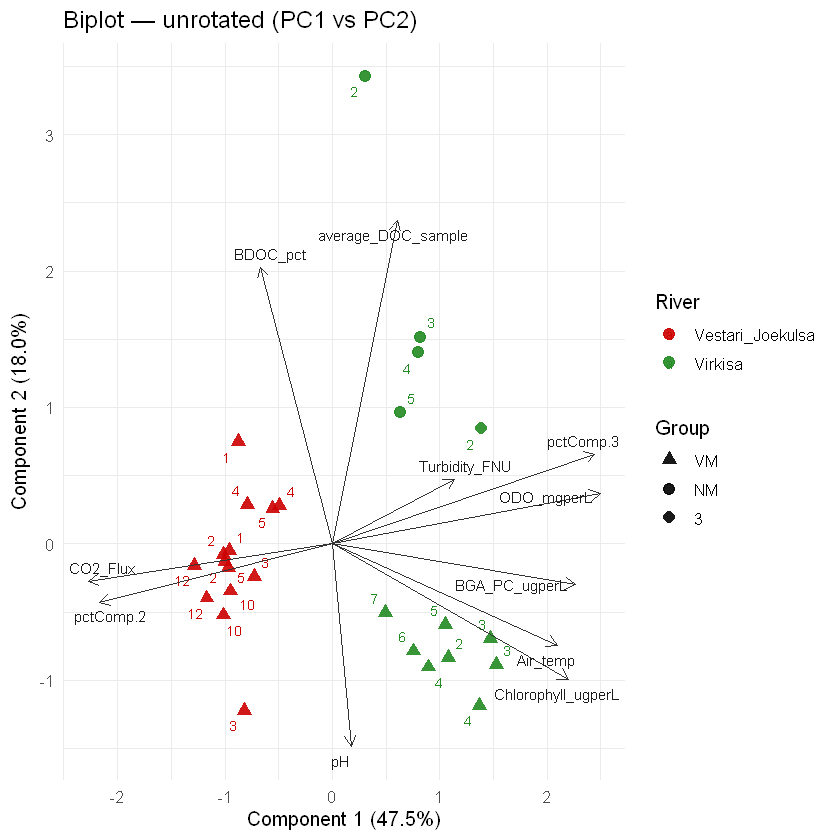

Custom biplots saved to: C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_flexibel/biplots


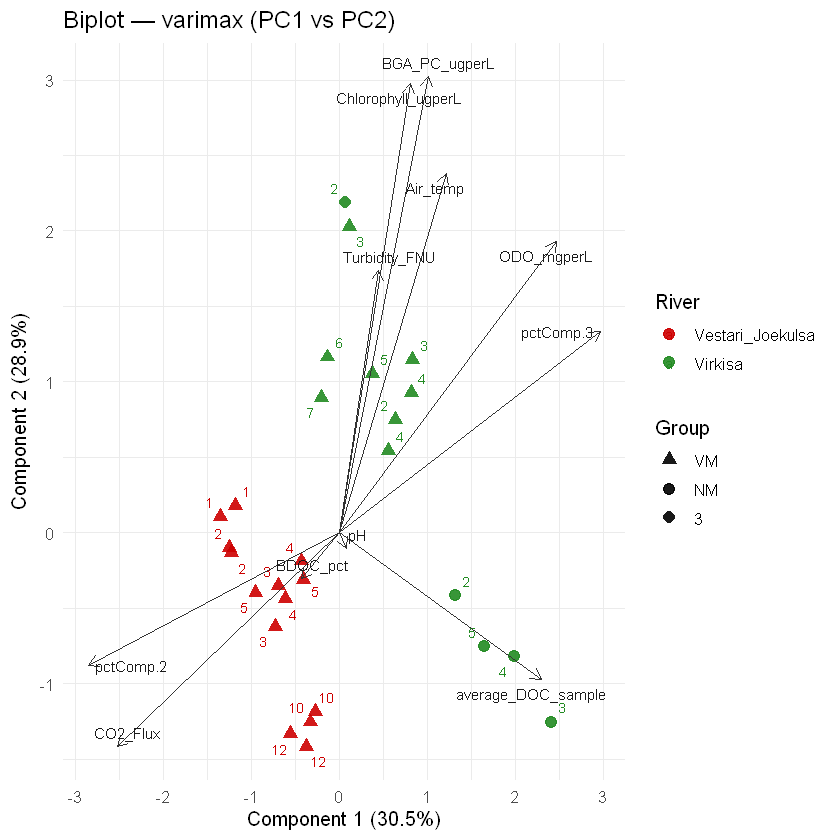

In [12]:
# ================================
# EXTRA (robust): Biplots with custom colors/shapes and safe scale matching
# ================================
suppressPackageStartupMessages({ library(ggplot2); library(ggrepel); library(dplyr); library(stringr) })

# --- helper: first existing column (case-insensitive)
pick_col <- function(df, choices){
  cn <- names(df)
  for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm))
    if(length(hit)) return(cn[hit[1]])
  }
  NULL
}

# rows used in PCA = complete cases of dat_num (wie oben)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# map source columns (from your list)
col_river <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_group <- pick_col(meta, c("group_nr","VM_NM","vm_nm","Group","group","type"))
col_label <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))

# fallbacks
if(is.null(col_river)) { meta$.__river__ <- NA_character_ ; col_river <- ".__river__" }
if(is.null(col_group)) { meta$.__group__ <- NA_character_ ; col_group <- ".__group__" }
if(is.null(col_label)) { meta$.__label__ <- seq_len(nrow(meta)) ; col_label <- ".__label__" }

# --- CLEAN VALUES ---
# unify river names to canonical labels we want to style
river_clean <- meta[[col_river]] |> as.character()
river_clean <- case_when(
  str_detect(river_clean, regex("virkisa", ignore_case = TRUE)) ~ "Virkisa",
  str_detect(river_clean, regex("^vestari", ignore_case = TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river_clean
)

# group: prefer explicit VM/NM strings; if numeric {1,2} try heuristic 1=VM,2=NM; else keep as is
grp_raw <- meta[[col_group]]
if(is.numeric(grp_raw) || is.integer(grp_raw)){
  grp_clean <- ifelse(grp_raw == 1, "VM",
                ifelse(grp_raw == 2, "NM", as.character(grp_raw)))
} else {
  grptxt <- as.character(grp_raw)
  grp_clean <- case_when(
    str_detect(grptxt, regex("^vm$", ignore_case=TRUE)) ~ "VM",
    str_detect(grptxt, regex("^nm$", ignore_case=TRUE)) ~ "NM",
    TRUE ~ grptxt
  )
}

lab_clean <- as.character(meta[[col_label]])

# replace missing/empty with explicit "(missing)" to avoid dropped levels
river_clean[is.na(river_clean) | river_clean==""] <- "(missing)"
grp_clean[is.na(grp_clean)   | grp_clean==""]     <- "(missing)"

# --- LEVELS & MANUAL MAPS that match exactly the data (prevents warnings) ---
river_lvls <- unique(river_clean)
group_lvls <- unique(grp_clean)

col_map <- setNames(rep("grey40", length(river_lvls)), river_lvls)
if("Vestari_Joekulsa" %in% river_lvls) col_map["Vestari_Joekulsa"] <- "red3"
if("Virkisa" %in% river_lvls)          col_map["Virkisa"]          <- "forestgreen"

shape_map <- setNames(rep(16, length(group_lvls)), group_lvls)
if("VM" %in% group_lvls) shape_map["VM"] <- 17
if("NM" %in% group_lvls) shape_map["NM"] <- 19

# factorise with these exact levels
meta$RiverF <- factor(river_clean, levels = river_lvls)
meta$GroupF <- factor(grp_clean,  levels = group_lvls)
meta$Label  <- lab_clean

# --- biplot builder (PC1 vs PC2), with axis variance labels ---
make_biplot <- function(scores, loads, var_prop, title_txt, file_png){
  df_sco <- as.data.frame(scores[,1:2, drop=FALSE]); names(df_sco) <- c("PC1","PC2")
  df_sco$RiverF <- meta$RiverF
  df_sco$GroupF <- meta$GroupF
  df_sco$Label  <- meta$Label

  L <- as.data.frame(loads[,1:2, drop=FALSE]); names(L) <- c("PC1","PC2"); L$var <- rownames(loads)

  # arrow scaling to score ranges
  rx <- diff(range(df_sco$PC1, na.rm=TRUE)); if(!is.finite(rx) || rx==0) rx <- 1
  ry <- diff(range(df_sco$PC2, na.rm=TRUE)); if(!is.finite(ry) || ry==0) ry <- 1
  maxL <- max(sqrt(L$PC1^2 + L$PC2^2), na.rm=TRUE); if(!is.finite(maxL) || maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls <- transform(L, PC1 = PC1 * scf, PC2 = PC2 * scf)

  ax1 <- paste0("Component 1 (", sprintf("%.1f", 100*var_prop[1]), "%)")
  ax2 <- paste0("Component 2 (", sprintf("%.1f", 100*var_prop[2]), "%)")

  p <- ggplot() +
    geom_point(data=df_sco, aes(PC1, PC2, color=RiverF, shape=GroupF), size=3, alpha=0.9, na.rm=TRUE) +
    ggrepel::geom_text_repel(data=df_sco, aes(PC1, PC2, label=Label, color=RiverF),
                             size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2, na.rm=TRUE) +
    geom_segment(data=Ls, aes(x=0, y=0, xend=PC1, yend=PC2),
                 arrow=arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(PC1, PC2, label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_color_manual(values = col_map, breaks = names(col_map), drop = FALSE) +
    scale_shape_manual(values = shape_map, breaks = names(shape_map), drop = FALSE) +
    labs(title=title_txt, x=ax1, y=ax2, color="River", shape="Group") +
    theme_minimal(base_size=12) + theme(legend.position="right")

  print(p)
  ggsave(file_png, p, width=20, height=16, units="cm", dpi=300)
}

# --- output dir ---
biplot_dir <- file.path(out_dir, "biplots")
if(!dir.exists(biplot_dir)) dir.create(biplot_dir, recursive = TRUE)

# --- create plots (need ≥2 components) ---
if(is.null(pca_unrot) || is.null(pca_rot) || is.null(pca_unrot$scores) || ncol(as.data.frame(pca_unrot$scores)) < 2){
  warning("Not enough components for 2D biplots.")
} else {
  # UNROTATED
  scr_un <- as.data.frame(pca_unrot$scores)
  lod_un <- as.matrix(unclass(pca_unrot$loadings))
  var_un <- as.numeric(pca_unrot$Vaccounted["Proportion Var", 1:2])
  make_biplot(scr_un, lod_un, var_un,
              "Biplot — unrotated (PC1 vs PC2)",
              file.path(biplot_dir, "Biplot_unrotated_PC1_PC2.png"))

  # VARIMAX
  scr_ro <- as.data.frame(pca_rot$scores)
  lod_ro <- as.matrix(unclass(pca_rot$loadings))
  var_ro <- as.numeric(pca_rot$Vaccounted["Proportion Var", 1:2])
  make_biplot(scr_ro, lod_ro, var_ro,
              "Biplot — varimax (PC1 vs PC2)",
              file.path(biplot_dir, "Biplot_varimax_PC1_PC2.png"))
}

cat("Custom biplots saved to: ", biplot_dir, "\n", sep="")


In [13]:
# ================================
# EXTRA: All biplot versions (psych grid + custom colored) with clear axes/titles
# ================================
suppressPackageStartupMessages({
  library(ggplot2); library(ggrepel); library(dplyr); library(stringr); library(psych)
})

# ---------- helpers ----------
pick_col <- function(df, choices){
  cn <- names(df)
  for(nm in choices){
    hit <- which(tolower(cn) == tolower(nm))
    if(length(hit)) return(cn[hit[1]])
  }
  NULL
}

# rows used in PCA (complete cases of dat_num)
row_idx <- complete.cases(dat_num)
meta <- raw[row_idx, , drop = FALSE]

# columns from your schema
col_river <- pick_col(meta, c("river_name","river_Name","river","River","Plot","plot"))
col_group <- pick_col(meta, c("group_nr","VM_NM","vm_nm","Group","group","type"))
col_label <- pick_col(meta, c("site_nr","Site","site","siteID","site_id","DOC_label"))

if(is.null(col_river)) { meta$.__river__ <- NA_character_; col_river <- ".__river__" }
if(is.null(col_group)) { meta$.__group__ <- NA_character_; col_group <- ".__group__" }
if(is.null(col_label)) { meta$.__label__ <- seq_len(nrow(meta)); col_label <- ".__label__" }

# clean values
river_clean <- as.character(meta[[col_river]])
river_clean <- case_when(
  str_detect(river_clean, regex("virkisa", ignore_case = TRUE)) ~ "Virkisa",
  str_detect(river_clean, regex("^vestari", ignore_case = TRUE)) ~ "Vestari_Joekulsa",
  TRUE ~ river_clean
)
grp_raw <- meta[[col_group]]
if(is.numeric(grp_raw) || is.integer(grp_raw)){
  grp_clean <- ifelse(grp_raw == 1, "VM", ifelse(grp_raw == 2, "NM", as.character(grp_raw)))
} else {
  grptxt <- as.character(grp_raw)
  grp_clean <- case_when(
    str_detect(grptxt, regex("^vm$", ignore_case=TRUE)) ~ "VM",
    str_detect(grptxt, regex("^nm$", ignore_case=TRUE)) ~ "NM",
    TRUE ~ grptxt
  )
}
lab_clean <- as.character(meta[[col_label]])

river_clean[is.na(river_clean)|river_clean==""] <- "(missing)"
grp_clean[is.na(grp_clean)|grp_clean==""]       <- "(missing)"

# factor levels & manual maps (exact match -> no warnings)
river_lvls <- unique(river_clean); group_lvls <- unique(grp_clean)
col_map <- setNames(rep("grey40", length(river_lvls)), river_lvls)
if("Vestari_Joekulsa" %in% river_lvls) col_map["Vestari_Joekulsa"] <- "red3"
if("Virkisa" %in% river_lvls)          col_map["Virkisa"]          <- "forestgreen"
shape_map <- setNames(rep(16, length(group_lvls)), group_lvls)
if("VM" %in% group_lvls) shape_map["VM"] <- 17
if("NM" %in% group_lvls) shape_map["NM"] <- 19

meta$RiverF <- factor(river_clean, levels = river_lvls)
meta$GroupF <- factor(grp_clean,  levels = group_lvls)
meta$Label  <- lab_clean

# dirs
dir_grid   <- file.path(out_dir, "biplots", "grid")
dir_custom <- file.path(out_dir, "biplots", "custom")
dir.create(dir_grid,   showWarnings = FALSE, recursive = TRUE)
dir.create(dir_custom, showWarnings = FALSE, recursive = TRUE)

# ---------- 1) psych grid (like your screenshot) ----------
save_psych_grid <- function(pca_obj, title_txt, file_png){
  graphics.off(); par(mfrow=c(1,1))
  biplot.psych(pca_obj, main = title_txt)  # show
  png(file_png, width = 1800, height = 1400, res = 180)
  par(mfrow=c(1,1))
  biplot.psych(pca_obj, main = title_txt)  # save
  dev.off()
}

# unrotated grid
save_psych_grid(pca_unrot, "Biplot — unrotated (psych grid)", 
                file.path(dir_grid, "Biplot_grid_unrotated.png"))
# varimax grid
save_psych_grid(pca_rot,   "Biplot — varimax (psych grid)",
                file.path(dir_grid, "Biplot_grid_varimax.png"))

# ---------- 2) custom colored biplots (PC pairs with labels) ----------
make_custom_biplot <- function(scores, loads, var_prop, i=1, j=2, title_txt, file_png){
  # scores
  df_sco <- as.data.frame(scores[, c(i,j), drop=FALSE])
  names(df_sco) <- c("x","y")
  df_sco$RiverF <- meta$RiverF
  df_sco$GroupF <- meta$GroupF
  df_sco$Label  <- meta$Label

  # loadings (variables)
  L <- as.data.frame(loads[, c(i,j), drop=FALSE])
  names(L) <- c("x","y")
  L$var <- rownames(loads)

  # scale arrows to fit score range
  rx <- diff(range(df_sco$x, na.rm=TRUE)); if(!is.finite(rx) || rx==0) rx <- 1
  ry <- diff(range(df_sco$y, na.rm=TRUE)); if(!is.finite(ry) || ry==0) ry <- 1
  maxL <- max(sqrt(L$x^2 + L$y^2), na.rm=TRUE); if(!is.finite(maxL) || maxL==0) maxL <- 1
  scf  <- 0.9 * min(rx, ry) / maxL
  Ls <- transform(L, x = x * scf, y = y * scf)

  ax_x <- paste0("Component ", i, " (", sprintf("%.1f", 100*var_prop[i]), "%)")
  ax_y <- paste0("Component ", j, " (", sprintf("%.1f", 100*var_prop[j]), "%)")

  p <- ggplot() +
    geom_point(data=df_sco, aes(x, y, color=RiverF, shape=GroupF), size=3, alpha=0.9, na.rm=TRUE) +
    ggrepel::geom_text_repel(data=df_sco, aes(x, y, label=Label, color=RiverF),
                             size=3, max.overlaps=Inf, box.padding=0.3, point.padding=0.2, na.rm=TRUE) +
    geom_segment(data=Ls, aes(x=0, y=0, xend=x, yend=y),
                 arrow=arrow(length=unit(0.25,"cm")), linewidth=0.4, color="grey20") +
    ggrepel::geom_text_repel(data=Ls, aes(x, y, label=var),
                             size=3.2, color="grey10", max.overlaps=Inf, box.padding=0.25) +
    scale_color_manual(values = col_map, breaks = names(col_map), drop = FALSE) +
    scale_shape_manual(values = shape_map, breaks = names(shape_map), drop = FALSE) +
    labs(title=title_txt, x=ax_x, y=ax_y, color="River", shape="Group") +
    theme_minimal(base_size=12) +
    theme(legend.position="right")

  print(p)
  ggsave(file_png, p, width=22, height=18, units="cm", dpi=300)
}

# safety: check we have ≥ 3 components for all pairs
get_max_comp <- function(pca_obj){
  min(ncol(as.data.frame(pca_obj$scores)), ncol(as.data.frame(unclass(pca_obj$loadings))))
}

# ---- UNROTATED custom biplots
nc_un <- get_max_comp(pca_unrot)
if(nc_un >= 2){
  scr_un <- as.data.frame(pca_unrot$scores)
  lod_un <- as.matrix(unclass(pca_unrot$loadings))
  var_un <- as.numeric(pca_unrot$Vaccounted["Proportion Var", 1:ncol(lod_un)])

  make_custom_biplot(scr_un, lod_un, var_un, i=1, j=2,
    title_txt="Colored biplot — unrotated (PC1 vs PC2)",
    file_png=file.path(dir_custom, "Custom_unrotated_PC1_PC2.png"))
  if(nc_un >= 3){
    make_custom_biplot(scr_un, lod_un, var_un, i=1, j=3,
      title_txt="Colored biplot — unrotated (PC1 vs PC3)",
      file_png=file.path(dir_custom, "Custom_unrotated_PC1_PC3.png"))
    make_custom_biplot(scr_un, lod_un, var_un, i=2, j=3,
      title_txt="Colored biplot — unrotated (PC2 vs PC3)",
      file_png=file.path(dir_custom, "Custom_unrotated_PC2_PC3.png"))
  }
}

# ---- VARIMAX custom biplots
nc_ro <- get_max_comp(pca_rot)
if(nc_ro >= 2){
  scr_ro <- as.data.frame(pca_rot$scores)
  lod_ro <- as.matrix(unclass(pca_rot$loadings))
  var_ro <- as.numeric(pca_rot$Vaccounted["Proportion Var", 1:ncol(lod_ro)])

  make_custom_biplot(scr_ro, lod_ro, var_ro, i=1, j=2,
    title_txt="Colored biplot — varimax (PC1 vs PC2)",
    file_png=file.path(dir_custom, "Custom_varimax_PC1_PC2.png"))
  if(nc_ro >= 3){
    make_custom_biplot(scr_ro, lod_ro, var_ro, i=1, j=3,
      title_txt="Colored biplot — varimax (PC1 vs PC3)",
      file_png=file.path(dir_custom, "Custom_varimax_PC1_PC3.png"))
    make_custom_biplot(scr_ro, lod_ro, var_ro, i=2, j=3,
      title_txt="Colored biplot — varimax (PC2 vs PC3)",
      file_png=file.path(dir_custom, "Custom_varimax_PC2_PC3.png"))
  }
}

cat("Saved psych grids to:   ", dir_grid, "\n", sep="")
cat("Saved custom biplots to:", dir_custom, "\n", sep="")


png 
  2

png 
  2

Saved psych grids to:   C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_flexibel/biplots/grid
Saved custom biplots to:C:/Users/sophia/Dropbox/MASTER/Master_Data_Table/FINAL/PCA_flexibel/biplots/custom
